In [1]:
import numpy as np
import pandas as pd
from pydicom import dcmread
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as T
import torch
import matplotlib.pyplot as plt

from src import *

In [47]:
annot = pd.read_csv('/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/modified_breast-level_annotations.csv')
annot

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training
...,...,...,...,...,...,...,...,...,...,...
19991,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training
19992,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training
19993,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training
19994,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training


In [2]:
loader = Patient_Cancer_Dataloader(
        root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
        annotation_csv="modified_breast-level_annotations.csv",
        imagefolder_path="New_512",
        batch_size=16,
        num_workers=8,
    )
train_l = loader.train_dataloader()
val_l = loader.val_dataloader()
test_l = loader.test_dataloader()


In [5]:
train_labels = []
val_labels = []
test_labels = []
for i,batch in enumerate(train_l):
    images, label = batch
    #print(i, type(label), label.shape)
    train_labels.append(label.numpy())
for i, batch in enumerate(val_l):
    images, label = batch
    #print(i, type(label), label.shape)
    val_labels.append(label.numpy())
for i, batch in enumerate(test_l):
    images, label = batch
    #print(i, type(label), label.shape)
    test_labels.append(label.numpy())
train_labels = np.concatenate(train_labels)
val_labels = np.concatenate(val_labels)
test_labels = np.concatenate(test_labels)

In [6]:
print(train_labels.shape, val_labels.shape, test_labels.shape)

(3200, 2) (799, 2) (1000, 2)


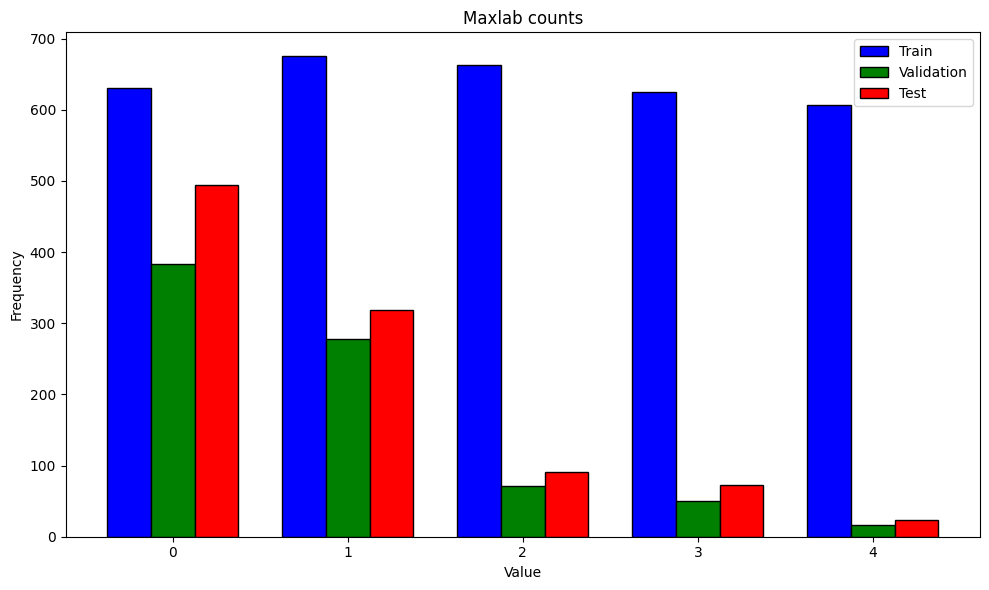

In [ ]:

train_maxlab = np.max(train_labels, axis = 1)
val_maxlab = np.max(val_labels, axis = 1)
test_maxlab = np.max(test_labels, axis = 1)
# Count unique values in maxlab vectors
train_counts = np.unique(train_maxlab, return_counts=True)
val_counts = np.unique(val_maxlab, return_counts=True)
test_counts = np.unique(test_maxlab, return_counts=True)

# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(train_counts[0]))

bar1 = ax.bar(index, train_counts[1], bar_width, label='Train', color='b', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_counts[1], bar_width, label='Validation', color='g', edgecolor='black')
bar3 = ax.bar(index + 2 * bar_width, test_counts[1], bar_width, label='Test', color='r', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Maxlab counts')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(train_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

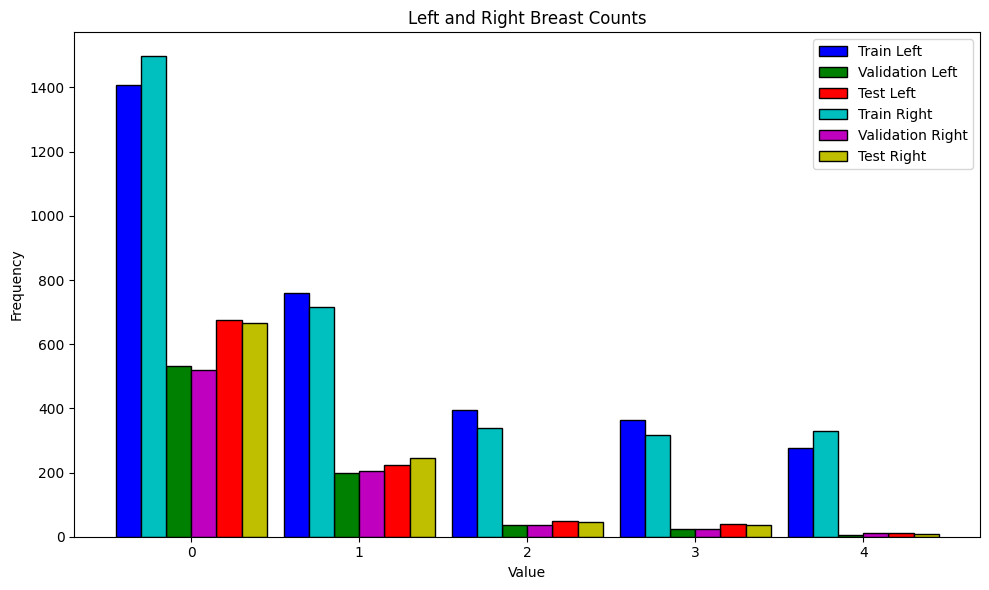

In [8]:

# Separate left and right breast labels
train_left = train_labels[:, 0]
train_right = train_labels[:, 1]
val_left = val_labels[:, 0]
val_right = val_labels[:, 1]
test_left = test_labels[:, 0]
test_right = test_labels[:, 1]

# Count unique values for left and right breast labels
train_left_counts = np.unique(train_left, return_counts=True)
train_right_counts = np.unique(train_right, return_counts=True)
val_left_counts = np.unique(val_left, return_counts=True)
val_right_counts = np.unique(val_right, return_counts=True)
test_left_counts = np.unique(test_left, return_counts=True)
test_right_counts = np.unique(test_right, return_counts=True)


# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(train_left_counts[0]))

# Plot for left breast
bar1 = ax.bar(index, train_left_counts[1], bar_width, label='Train Left', color='b', edgecolor='black')
bar2 = ax.bar(index + 2 * bar_width, val_left_counts[1], bar_width, label='Validation Left', color='g', edgecolor='black')
bar3 = ax.bar(index + 4 * bar_width, test_left_counts[1], bar_width, label='Test Left', color='r', edgecolor='black')

# Plot for right breast
bar4 = ax.bar(index + bar_width, train_right_counts[1], bar_width, label='Train Right', color='c', edgecolor='black')
bar5 = ax.bar(index + 3 * bar_width, val_right_counts[1], bar_width, label='Validation Right', color='m', edgecolor='black')
bar6 = ax.bar(index + 5 * bar_width, test_right_counts[1], bar_width, label='Test Right', color='y', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Left and Right Breast Counts')
ax.set_xticks(index + 2.5 * bar_width)
ax.set_xticklabels(train_left_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

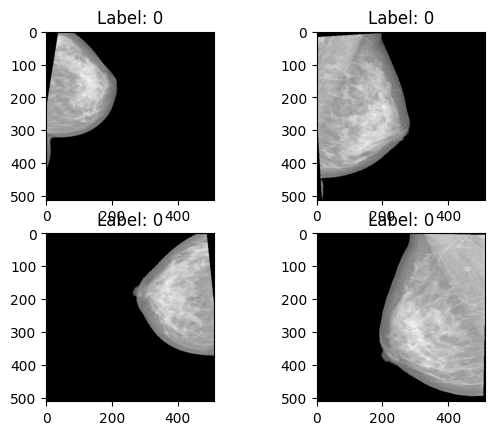

In [7]:
loader.plot(3)

3200


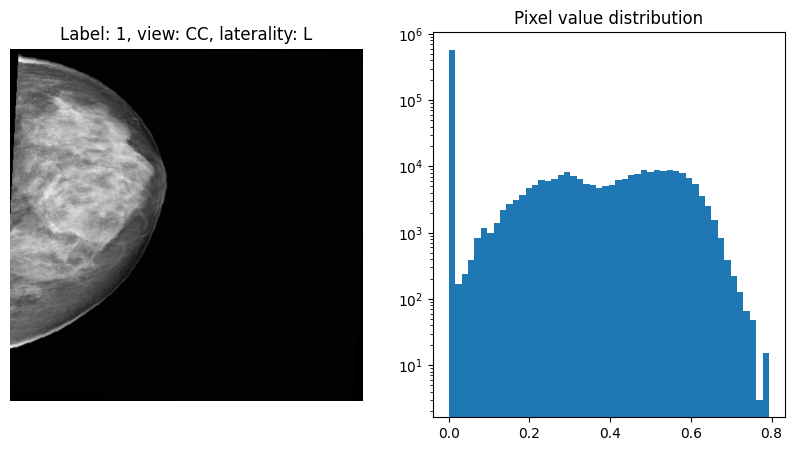

Compose(
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[781.0543, 781.0543, 781.0543], std=[1537.8235, 1537.8235, 1537.8235], inplace=False)
      RandomAdjustSharpness(p=1, sharpness_factor=1)
      ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
)

In [10]:
from src import *
train_transform = T.Compose(
        [
            T.ToImage(),
            # T.RandomRotation(degrees=10),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(
                mean=[781.0543, 781.0543, 781.0543],
                std=[1537.8235, 1537.8235, 1537.8235],
            ),
            T.RandomAdjustSharpness(sharpness_factor=1, p=1),
            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomRotation(degrees=10),
        ]
    )
view_loader = View_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    batch_size=16,
    num_workers=8,
    view='CC',
    laterality='L',
    train_transform=train_transform,
)
print(view_loader.train_dataset.__len__())
view_loader.plot(0)
view_loader.train_transform

In [9]:
# histogram of labels of train, val, test datasets
train_labels = []
val_labels = []
test_labels = []
for i,batch in enumerate(view_loader.train_dataloader()):
    images, label = batch
    #print(i, type(label), label.shape)
    train_labels.append(label.numpy())
for i, batch in enumerate(view_loader.val_dataloader()):
    images, label = batch
    #print(i, type(label), label.shape)
    val_labels.append(label.numpy())
for i, batch in enumerate(view_loader.test_dataloader()):
    images, label = batch
    #print(i, type(label), label.shape)
    test_labels.append(label.numpy())
train_labels = np.concatenate(train_labels)
val_labels = np.concatenate(val_labels)
test_labels = np.concatenate(test_labels)



(3200,) (799,) (1000,)


NameError: name 'plt' is not defined

(3200,) (799,) (1000,)


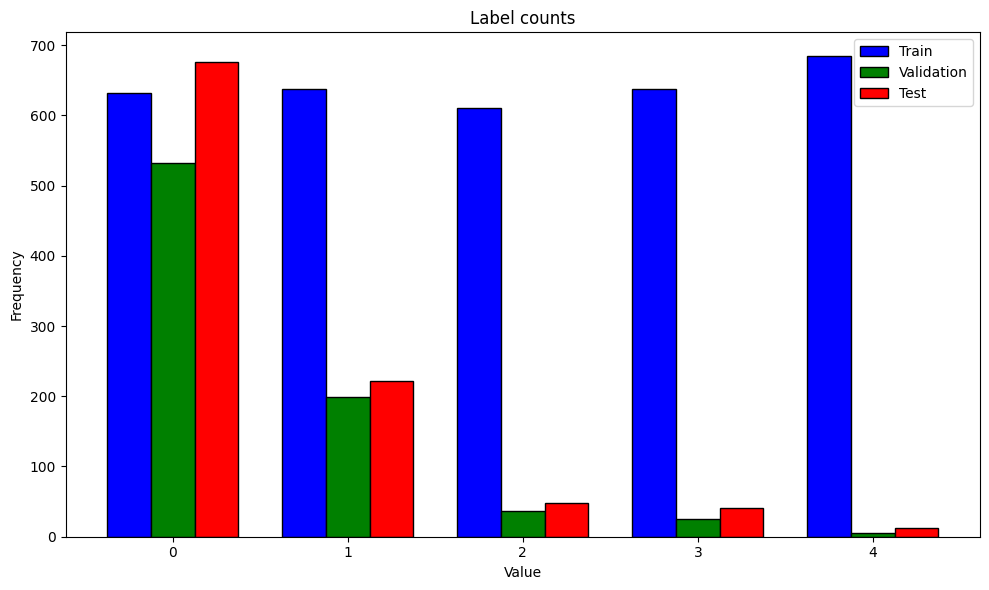

In [11]:
print(train_labels.shape, val_labels.shape, test_labels.shape)

# Count unique values in labels vectors
train_counts = np.unique(train_labels, return_counts=True)
val_counts = np.unique(val_labels, return_counts=True)
test_counts = np.unique(test_labels, return_counts=True)

# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(train_counts[0]))

bar1 = ax.bar(index, train_counts[1], bar_width, label='Train', color='b', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_counts[1], bar_width, label='Validation', color='g', edgecolor='black')
bar3 = ax.bar(index + 2 * bar_width, test_counts[1], bar_width, label='Test', color='r', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Label counts')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(train_counts[0])
ax.legend()

plt.tight_layout()
plt.show()